# Capstone 2 Project: Twitter Sentiment Analysis



## Table of Contents

* [Chapter 1](#chapter1)
    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)


## 1. Introduction

Microblogging websites such as Twitter have started to become a source of varied information about users' opinions on a variety of topics and/or products. Polling on microblogs can give a sense of general sentiment towards a topic or product and can be used by companies to study user reactions. Therefore a technology is necessary to detect and summarize overall sentiment.
Here, I build models for binary classification of sentiment of tweets into positive and negative classes.
I use a dataset of 10,000 human annotated tweets on the novel Coronavirus collected in 2020 (https://www.kaggle.com/imranzaman5202/covid19-sentiment-analysis).
The dataset was obtained via Twitter search (not streaming??) API collecting tweets against the keyword “coronavirus”. More details can be found in the link.
Sentiment analysis is performed using the nltk and scikitlearn packages in Python and following the steps outlined here: https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk


##  2. Data Preparation and Cleaning

In [1]:
#import packages 
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [2]:
#import tweet data
data = pd.read_csv("tweets_tagged.csv",delimiter=',', encoding='latin-1')
print(data.head())
print(data.describe())

   Sr No                                              tweet  label
0      1  Hysteria surrounding #coronavirus NZ daycare r...      3
1      2  Thank you @TheOnion for dragging all of us und...      1
2      3  #avetmissdone is catching on faster than the #...      1
3      4  They just said #Tonysnell was back from the fl...      2
4      5  Forget locking them up on an island to die slo...      2
             Sr No         label
count  10000.00000  10000.000000
mean    5000.50000      1.879200
std     2886.89568      0.784518
min        1.00000      1.000000
25%     2500.75000      1.000000
50%     5000.50000      2.000000
75%     7500.25000      3.000000
max    10000.00000      3.000000


In [3]:
#remove urls 
def remove_URL(sample):
    """Remove URLs from a string"""
    return re.sub(r"http\S+", "", sample)
print(data['tweet'][1])
data['tweet']=[remove_URL(tweet) for tweet in data['tweet']]
print(data['tweet'][1])

Thank you @TheOnion for dragging all of us under the artful guise of satire. V helpful #coronavirus advice ?? https://t.co/Oly95Sul5f
Thank you @TheOnion for dragging all of us under the artful guise of satire. V helpful #coronavirus advice ?? 


In [4]:
#seperate dataframe to positive, negative, and both tweets
pos_tweets =data['tweet'][data['label']==1]
neg_tweets = data['tweet'][data['label']==3]
pos_neg_tweets = data['tweet'][data['label']!=2]


In [5]:
#to lower case  
pos_neg_tweets = [tweet.lower() for tweet in pos_neg_tweets]
pos_tweets = [tweet.lower() for tweet in pos_tweets]
neg_tweets = [tweet.lower() for tweet in neg_tweets]

In [6]:
print(pos_tweets[:5])
print(neg_tweets[:5])

['thank you @theonion for dragging all of us under the artful guise of satire. v helpful #coronavirus advice ?? ', '#avetmissdone is catching on faster than the #coronavirus... but no deaths yet! ??', '#wuhancoronavirus #coronavirus\na young man was recovered and discharged from a local hospital in shanxi. best wishes! ???\n', '#wuhancoronavirus #coronavirus\na young man was recovered and discharged from the local hospital in shanxi. best wishes! ????????? ', 'japan flies citizens home from virus-hit wuhan  via @youtube #coronavirus ??']
['hysteria surrounding #coronavirus nz daycare requesting all children who have visited a country with any confirmed cases be excluded for 2 weeks. this includes australia. so, despite us only visiting adelaide where there are no confirmed cases, we are in this category ??', 'please keep posted!?????? #coronavirus #gensan #stelizabethhospitalinc #sehi ', 'what did richard jefferson say? ?? #coronavirus ', 'halt???\nall??commercial??flights??from #china

In [7]:
#convert emoticons to words before tokenizing, so they don't get deleted

# Function for converting emoticons into word

def convert_emoticons(text):
    for emot in EMOTICONS:
        emo_string= "_".join(EMOTICONS[emot].replace(",","").split())
        text = re.sub(u'('+emot+')',emo_string, text)
        text=text.replace("_".join(EMOTICONS[emot].replace(",","").split()), " "+"_".join(EMOTICONS[emot].replace(",","").split()))
    return text

#count emoticons - why doesnt this work??

count_emot=0
def count_emoticons(text):
    for emot in EMOTICONS:
        global count_emot
        #emot="\"%s\"" % emot
        count_emot+=text.count(emot)
    return count_emot
    

#example
text2 = "Hilarious:-). The feeling of making a sale :-(, The feeling of actually fulfilling orders :-)"

print(convert_emoticons(text2))
print(count_emoticons( "Hilarious:-)."))


Hilarious           Happy_face_smiley. The feeling of making a sale              Frown_sad_andry_or_pouting, The feeling of actually fulfilling orders            Happy_face_smiley
0


In [8]:
#use Tweet tokenizer (preserves hashtag and @)
tknzr = TweetTokenizer()

pos_tokens = [tknzr.tokenize(tweet) for tweet in pos_tweets]
neg_tokens = [tknzr.tokenize(tweet) for tweet in neg_tweets]
tweet_tokens = [tknzr.tokenize(tweet) for tweet in pos_neg_tweets]
print(pos_tokens[1])
print(neg_tokens[1])
print(tweet_tokens[1])

['#avetmissdone', 'is', 'catching', 'on', 'faster', 'than', 'the', '#coronavirus', '...', 'but', 'no', 'deaths', 'yet', '!', '?', '?']
['please', 'keep', 'posted', '!', '?', '?', '?', '#coronavirus', '#gensan', '#stelizabethhospitalinc', '#sehi']
['thank', 'you', '@theonion', 'for', 'dragging', 'all', 'of', 'us', 'under', 'the', 'artful', 'guise', 'of', 'satire', '.', 'v', 'helpful', '#coronavirus', 'advice', '?', '?']


In [9]:
#normalization 
#tagging position of word in sentence
#show example for first tweet
print(pos_tag(pos_tokens[0]))

[('thank', 'NN'), ('you', 'PRP'), ('@theonion', 'VBP'), ('for', 'IN'), ('dragging', 'VBG'), ('all', 'DT'), ('of', 'IN'), ('us', 'PRP'), ('under', 'IN'), ('the', 'DT'), ('artful', 'JJ'), ('guise', 'NN'), ('of', 'IN'), ('satire', 'NN'), ('.', '.'), ('v', 'NN'), ('helpful', 'JJ'), ('#coronavirus', 'NN'), ('advice', 'NN'), ('?', '.'), ('?', '.')]


In [10]:
#remove noise and lemmatize (copy and pasted from blog)

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
    
        #token = re.sub("(@[A-Za-z0-9_]+)","", token) #this would delete @handles?
        token=re.sub("([^A-Za-z#])","", token) #this deletes all numbers and punctuations, though it also transforms #ncov19 to #ncov
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        #use if condition to drop single character strings
        if len(token) > 1 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [11]:
#define stopwords to remove
stop_words = stopwords.words('english')

In [12]:
#apply remove_noise function
pos_tokens_cleaned = []
neg_tokens_cleaned = []
tweet_tokens_cleaned = []

for tokens in pos_tokens:
    pos_tokens_cleaned.append(remove_noise(tokens, stop_words))

for tokens in neg_tokens:
    neg_tokens_cleaned.append(remove_noise(tokens, stop_words))

for tokens in tweet_tokens:
    tweet_tokens_cleaned.append(remove_noise(tokens, stop_words))

### 2. Exploratory Data Analysis

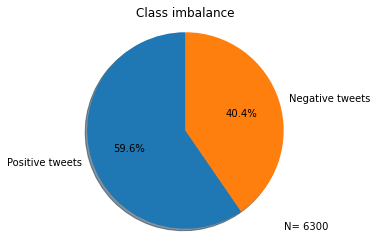

In [13]:
#examine the data
#share of positive tweets

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Positive tweets', 'Negative tweets'
shares = [len(pos_tweets)/len(pos_neg_tweets), (1-len(pos_tweets)/len(pos_neg_tweets))]
fig1, ax1 = plt.subplots()
ax1.pie(shares, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
n=len(pos_neg_tweets)
plt.text(1, -1, "N= %d" % n)
plt.title("Class imbalance")

plt.show()

In [14]:
#count words to later drop most frequent words and plot a histogram

word_counter={}
for tweet in tweet_tokens_cleaned:
    for word in tweet:
        if word != '':
            if word in word_counter:
                word_counter[word] +=1
            else:
                word_counter[word] = 1

popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_200 = popular_words[:200]
top_50=popular_words[:50]
top_10 = popular_words[:10]


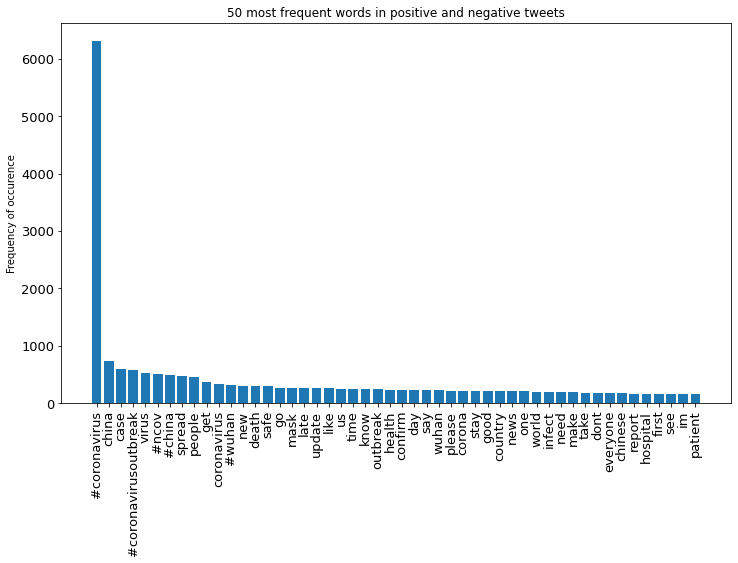

In [15]:
#plot most distribution of 50 most common words
#get values of word_counter for most common 50 words
freq = []
words = []
sorted_freq=dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))
for key, value in sorted_freq.items():
    if key in top_50:
        freq.append(value)
        words.append(key)
#make bar plot of most frequent words
fig, ax = plt.subplots(figsize=(12, 7))
plt.bar(height=freq, x=words, width=0.8)
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("50 most frequent words in positive and negative tweets")
plt.ylabel("Frequency of occurence")
plt.show()


In [16]:
#make list of pos and negative words from list of tweets 
#to be able to delete most frequent words and count words looping over list
pos_words = []
neg_words = []

for tweet in pos_tokens_cleaned:
    for word in tweet:
        pos_words.append(word)
        
for tweet in neg_tokens_cleaned:
    for word in tweet:
        neg_words.append(word)

In [17]:
#count and plot top words in positive and negative tweets that are not in top_10
count_pos={}
for word in pos_words:
    if word not in top_10:
        if word in count_pos:
            count_pos[word] +=1
        else:
            count_pos[word] = 1

popular_pos_words = sorted(count_pos, key = count_pos.get, reverse = True)
top_20_pos_words=popular_pos_words[:20]
count_neg={}
for word in neg_words:
    if word not in top_10:
        if word in count_neg:
            count_neg[word] +=1
        else:
            count_neg[word] = 1

In [18]:
#get frequencies from dictionaries in a sorted way as tuples for plotting top20
#positive
freq_pos = []
words_pos = []
sorted_freq_pos= [(k, v) for k, v in count_pos.items()]
sorted_freq_pos=sorted(sorted_freq_pos, key=lambda tup: tup[1], reverse=True)
words_pos = [a for (a,_) in sorted_freq_pos]
freq_pos = [b for (_,b) in sorted_freq_pos]

In [19]:
#negative
freq_neg = []
words_neg = []
sorted_freq_neg= [(k, v) for k, v in count_neg.items()]
sorted_freq_neg=sorted(sorted_freq_neg, key=lambda tup: tup[1], reverse=True)
words_neg = [a for (a,_) in sorted_freq_neg]
freq_neg = [b for (_,b) in sorted_freq_neg]

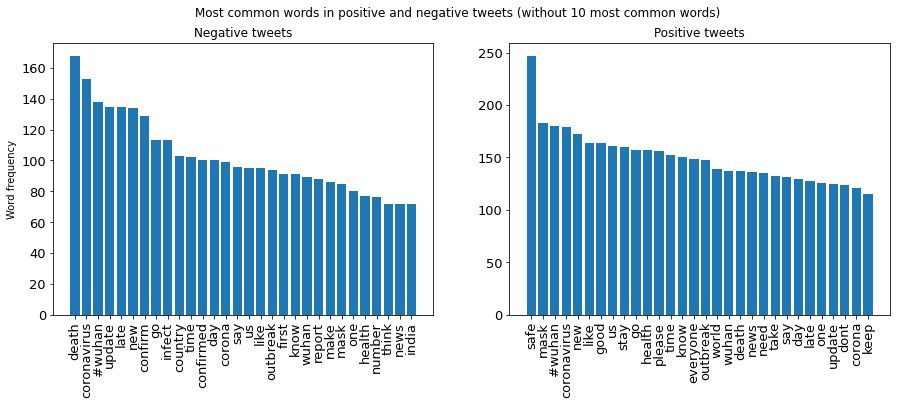

In [20]:
#make bar plot of frequencies 
fig, ax = plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)

#This will create first plot
neg = plt.bar(words_neg[:30], freq_neg[:30])
plt.title('Negative tweets')
plt.ylabel('Word frequency')
plt.xticks(rotation='vertical')
plt.tick_params(axis='both', which='major', labelsize=13)
#The below code will create the second plot.
plt.subplot(1,2,2)
#This will create the second plot
pos =plt.bar(words_pos[:30], freq_pos[:30])
plt.title('Positive tweets')
plt.xticks( rotation='vertical')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.suptitle('Most common words in positive and negative tweets (without 10 most common words)')
plt.show() 

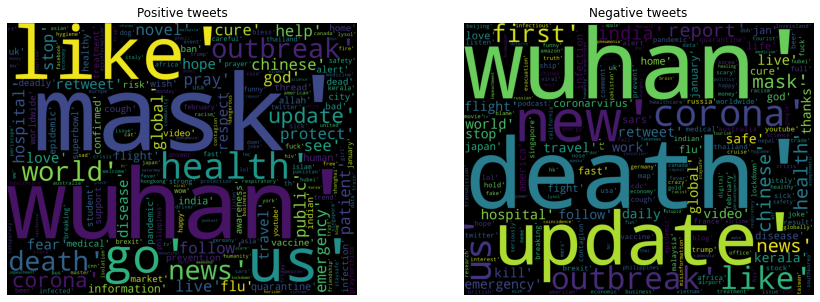

In [21]:
#in addition make word cloud as alternative illustration

from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=(15, 5))

#positive
plt.subplot(1,2,1)
wordcloud_pos = WordCloud(width=1800,height=1400).generate(str(words_pos))
plt.imshow(wordcloud_pos)
plt.title('Positive tweets')
plt.axis("off")

#negative
plt.subplot(1,2,2)
wordcloud_neg = WordCloud(width=1800,height=1400).generate(str(words_neg))
plt.imshow(wordcloud_neg)
plt.title('Negative tweets')
plt.axis("off")

plt.show()

## 3. Modelling

In [22]:
#preparing data for modelling

#make dict out of lists of tokens with keys = tokens and values=true

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(pos_tokens_cleaned)
negative_tokens_for_model = get_tweets_for_model(neg_tokens_cleaned)

In [23]:
#test and training set split 

#joining positive and negative tweets with additional tag, and shuffle into 1 set
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)


In [24]:
#Transform dataset to use with models from sklearn package
#requires count vectorization 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [25]:
#to use count vectorization, format of x (tweets) needs to be a simple list of strings
# Create our vectorizer
vectorizer = CountVectorizer()

neg_list = []
pos_list = []

for tweet in neg_tokens_cleaned:
    tw=''
    for word in tweet:
        tw=tw+word+' '
    tw=tw[:-1] #get rid of space at the end of tweet
    neg_list.append(tw)

for tweet in pos_tokens_cleaned:
    tw=''
    for word in tweet:
        tw=tw+word+' '
    tw=tw[:-1] #get rid of space at the end of tweet
    pos_list.append(tw)
    
#add positive and negative category and shuffle

pos_set = [(tweet, 1)
                     for tweet in pos_list]

neg_set = [(tweet, 0)
                     for tweet in neg_list]

ds = pos_set + neg_set
random.shuffle(ds)

# # set training dataset size to 0.7 of all data
# train_size=int(len(ds)*0.7) 
# train_data = ds[:train_size]
# test_data = ds[train_size:]

#generate X 
X = [a for (a,_) in ds]

X=vectorizer.fit_transform(X).toarray()

#generate y 
y = [b for (_,b) in ds]

#train test split: set training dataset size to 0.7 of all data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#for every column, drop if all rows are 0


#THIS GIVES DIFFERENT NO OF COLUMNS FOR TEST AND TRAIN DATA AND CAUSES ERRORS IN SUBSEQUENT ANALYSES
# # #find index of columns that have all 0 and delete these columns
# print(X_train.shape, X_test.shape)
# idx = np.argwhere(np.all(X_train[..., :] == 0, axis=0))
# X_train=np.delete(X_train, idx, axis=1)
# #idx = np.argwhere(np.all(X_test[..., :] == 0, axis=0))
# #X_test=np.delete(X_test, idx, axis=1)
# print(X_train.shape, X_test.shape, len(y_train), len(y_test))


### a. Naive Bayes Classifier

The multinomial naive Bayes classifier is a simple classification algorithm that naively assumes independence of features. It treats the text document as a "bag-of-words", that is, an unordered set of words with their position ignored, keeping only their frequency in the document, and assumes that the probabilities of all words are independent of eachother. Naive Bayes is a probabilistic classifier, meaning that for a document d, out of all classes c ∈ C the classifier returns the class which has the maximum posterior probability given the document p(features|class) (source: https://web.stanford.edu/~jurafsky/slp3/4.pdf). 


In [26]:
#Naive Bayes
# Build the classifier
naive_bayes= MultinomialNB(alpha=.01)

#  Train the classifier
naive_bayes.fit(X_train, y_train)

# Predict and score the vectors
nb_pred = naive_bayes.predict(X_test)
nb_acc_score = metrics.accuracy_score(y_test, nb_pred)
nb_f1_score = metrics.f1_score(y_test, nb_pred, average='macro')
nb_roc_auc_score =metrics.roc_auc_score(y_test, nb_pred)
nb_precision =metrics.precision_score(y_test, nb_pred)
nb_recall =metrics.recall_score(y_test, nb_pred)
    
print('Naive Bayes: Total accuracy classification score: {}'.format(nb_acc_score))
print('Naive Bayes: Total F1 classification score: {}'.format(nb_f1_score))
print('Naive Bayes: Recall score: {}'.format(nb_recall))
print('Naive Bayes: Precision score: {}'.format(nb_precision))
print('Naive Bayes: ROC-AUC score: {}'.format(nb_roc_auc_score))


Naive Bayes: Total accuracy classification score: 0.5962962962962963
Naive Bayes: Total F1 classification score: 0.5850610825466805
Naive Bayes: Recall score: 0.6385435168738899
Naive Bayes: Precision score: 0.6688372093023256
Naive Bayes: ROC-AUC score: 0.5862874652432276


### b. Logistic Regression 
While Naive Bayes is a generative classifier, whicht computes p(features|class) first, logistic regression is a popular discriminative classifier, meaning it allows to directly compute p(class|features) (https://towardsdatascience.com/sentiment-classification-with-logistic-regression-analyzing-yelp-reviews-3981678c3b44#c3b8).
Logistic regression is a supervised classification algorithm. The model builds a regression model to predict the probability that a given data entry belongs to the class numbered as “1”. Just like Linear regression assumes that the data follows a linear function, Logistic regression models the data using the sigmoid function. Logistic regression becomes a classification technique only when a decision threshold is chosen. (https://www.geeksforgeeks.org/understanding-logistic-regression/#:~:text=Logistic%20regression%20is%20basically%20a,regression%20IS%20a%20regression%20model.)
A parameter to be adjusted is the regularization parameter C. It applies a pply a penalty to increase the magnitude of parameter values in order to avoid overfitting. 

In [45]:
#Logistic regression

#with default hyperparameters to draw curves later
logistic= LogisticRegression()


# Build the classifier with different values of regularization strengths (c) with own function

def logreg(cval):
    lr= LogisticRegression(C=cval, max_iter=1000)
    lr.fit(X_train, y_train) #train
    lr_pred = lr.predict(X_test) #predict
    lr_acc_score = metrics.accuracy_score(y_test, lr_pred)
    lr_roc_auc_score =metrics.roc_auc_score(y_test, lr_pred)
    lr_precision =metrics.precision_score(y_test, lr_pred)
    lr_recall =metrics.recall_score(y_test, lr_pred)
    lr_f1_score = metrics.f1_score(y_test, lr_pred, average='macro')
    return lr_acc_score, lr_f1_score, lr_recall, lr_precision, lr_roc_auc_score, lr

    # Predict and score the vectors for different values of C (with Max_iter=1000 instead of 100, it converges)
c=[0.001, 0.01, 0.1, 1,10,100]
class_weight=[None, 'balanced']

for  cval in c:
    print('Logistic Regression for C=%f:' % (cval) ) 
    print('Accuracy: %f, Total F1 classification score: %f, Recall: %f , Precision: %f , ROC AUC Score: %f' %  (logreg(cval)[0], logreg(cval)[1], logreg(cval)[2], logreg(cval)[3], logreg(cval)[4]))

Logistic Regression for C=0.001000:
Accuracy: 0.595767, Total F1 classification score: 0.373342, Recall: 1.000000 , Precision: 0.595767 , ROC AUC Score: 0.500000
Logistic Regression for C=0.010000:
Accuracy: 0.614286, Total F1 classification score: 0.452679, Recall: 0.971581 , Precision: 0.610832 , ROC AUC Score: 0.529639
Logistic Regression for C=0.100000:
Accuracy: 0.616402, Total F1 classification score: 0.539345, Recall: 0.860568 , Precision: 0.630449 , ROC AUC Score: 0.558556
Logistic Regression for C=1.000000:
Accuracy: 0.607937, Total F1 classification score: 0.574062, Recall: 0.746892 , Precision: 0.648419 , ROC AUC Score: 0.575017
Logistic Regression for C=10.000000:
Accuracy: 0.588889, Total F1 classification score: 0.567852, Recall: 0.679396 , Precision: 0.647756 , ROC AUC Score: 0.567447
Logistic Regression for C=100.000000:
Accuracy: 0.584127, Total F1 classification score: 0.567367, Recall: 0.655417 , Precision: 0.649648 , ROC AUC Score: 0.567237


In [46]:
#Logistic Regression with GridSearchCV with full parameter grid

##apply GridSearchCV to find best parameters for logistic regression

# Setup the hyperparameter grid
c_space = [0.001, .01, .1, 1, 10, 100]
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']

param_grid = dict(solver=solvers,penalty=penalty,C=c_space)

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid, cv=5, scoring="roc_auc", n_jobs=-1)

# Fit it to the train data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score is 0.6102482029310776


In [50]:
#make logistic classifier with tuned parameters
logistic_tuned=LogisticRegression(C=0.01, penalty='l2', solver='newton-cg')


### c. Decision Tree Classification
Decision Trees are among the most popular classification algorithm due to their robustness to noise, tolerance against missing information, handling of irrelevant, redundant predictive attribute values, low computational cost, interpretability, fast run time and robust predictors.

In [48]:
# Instantiate classifier
dectree = DecisionTreeClassifier()


In [49]:
#Decision Trees with GridSearchCV

##apply GridSearchCV to find best parameters for Decision Tree

# Setup the hyperparameter grid
criterion=['gini', 'entropy']
    #class weight= balanced
class_weight=['balanced', 'none']
    #random splitter
splitter=['best', 'random']
param_grid = {'criterion':criterion, 'class_weight': class_weight, 'splitter':splitter}


# Instantiate the GridSearchCV object: logreg_cv
dectree_cv = GridSearchCV(dectree,param_grid, cv=3, scoring="roc_auc", n_jobs=-1)

# Fit it to the data
dectree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Params: {}".format(dectree_cv.best_params_)) 
print("Best score is {}".format(dectree_cv.best_score_))

Tuned Decision Tree Params: {'class_weight': 'balanced', 'criterion': 'entropy', 'splitter': 'random'}
Best score is 0.5582207795868374


In [51]:
#make decision tree with tuned params
decision_tree_tuned = DecisionTreeClassifier(class_weight= 'balanced', criterion= 'entropy', splitter='random')

### d: Random forest 
Random forest is an ensemble model using bagging as the ensemble method and decision tree as the individual model. It selects n random subsets from the training set, trains n decision trees based on a random subset of features, makes individual independent predicitons on test set, and makes the final prediction via majority vote.

In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#fit model with different n_estimator values and plot performance
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 50)]
#store scores in dict
scores={}
for i in n_estimators:
    #Instantiate the classifier
    rf=RandomForestClassifier(n_estimators=i)
    #fit
    rf.fit(X_train, y_train)
    #predict probabilities
    prob=rf.predict_proba(X_test)[:, 1]
    # calculate roc auc scores
    auc = roc_auc_score(y_test, prob)
    scores[i]=auc
    

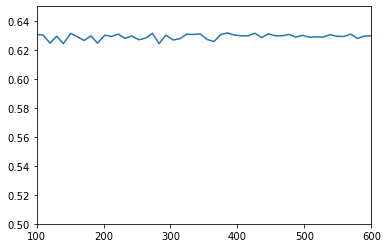

In [36]:
#plot ROC AUC score by n_estimators
keys = scores.keys()
values = scores.values()
plt.ylim([0.5,0.65])
plt.xlim([100,600])
plt.plot(keys, values)

In [37]:
#random hyperparameter grid
from sklearn.model_selection import RandomizedSearchCV
#Instantiate the classifier
rf=RandomForestClassifier()

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [38]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_train, y_train)
#print best params from random search
print(rf_random.best_params_)
print(rf_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 66.7min finished


{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
0.6149201297603124


In [39]:
#Random forest classifier with GridSearchCV based on what was found in random search and n_estimator tuning
n_estimators = [350,400,550]

# Number of trees in random forest

# # Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 50, num = 3)]
min_samples_leaf= [1, 2]
min_samples_split = [3,5,7]
# Create the parameter grid
param_grid = {'n_estimators': n_estimators, 'max_features' : max_features, 'max_depth' : max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split':min_samples_split}

# Instantiate the GridSearchCV object: rf_cv
rf_cv = GridSearchCV(rf,param_grid, cv=3, scoring='roc_auc', n_jobs = -1)

# Fit it to the data
rf_cv.fit(X_train, y_train)



GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [30, 40, 50], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [350, 400, 550]},
             scoring='roc_auc')

In [40]:
# Print the tuned parameters and score
print("Tuned Random forest Params: {}".format(rf_cv.best_params_)) 
print("Best score is {}".format(rf_cv.best_score_))


Tuned Random forest Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Best score is 0.6174588349245883


In [60]:
#make model with tuned parameter
random_forest_tuned=RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 5,n_estimators= 400)

### e. Support Vector Machines (SVM)

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

In [61]:
#support vector mechines (SVM)
from sklearn.svm import SVC
#initiate model
svm = SVC(probability=True)

In [42]:
#tune hyperparameters with GridSearchCV
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_cv = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, scoring="roc_auc")
  
# fitting the model for grid search
svm_cv.fit(X_train, y_train)

print("Tuned SVM Params: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))


Tuned SVM Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score is 0.6011308544603825


In [57]:
#make model with tuned parameters
svm_tuned=SVC(C= 1, gamma= 0.1, kernel= 'rbf', probability=True)

## 4. Model comparison and evaluation

The ROC-AUC score is used for model evaluation and is preferred over accuracy in unbalanced classification. The AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.
The ROC curve is plotted as the True positive rate (TPR) against the False positive rate (FPR), where TPR is on the y-axis and FPR is on the x-axis. An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has AUC near to the 0 which means it has the worst measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever. (Source: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5#:~:text=AUC%20%2D%20ROC%20curve%20is%20a,capable%20of%20distinguishing%20between%20classes.)

Model=MultinomialNB(alpha=0.01): ROC AUC=0.610
Model=LogisticRegression(): ROC AUC=0.628
Model=LogisticRegression(C=0.01, solver='newton-cg'): ROC AUC=0.626
Model=DecisionTreeClassifier(): ROC AUC=0.546
Model=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       splitter='random'): ROC AUC=0.547
Model=RandomForestClassifier(): ROC AUC=0.627
Model=RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=400): ROC AUC=0.629
Model=SVC(probability=True): ROC AUC=0.616
Model=SVC(C=1, gamma=0.1, probability=True): ROC AUC=0.616


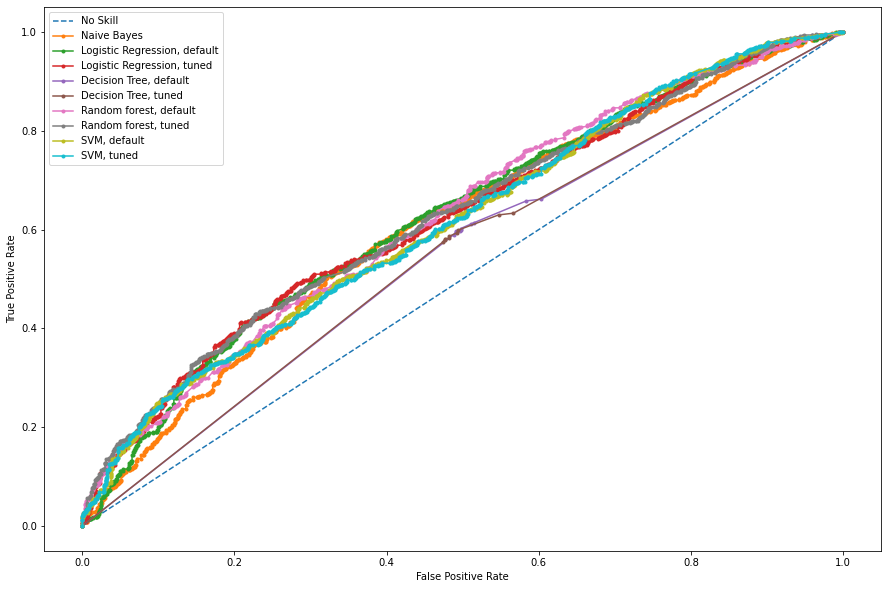

In [63]:
#Function for plotting ROC AUC Curve
#import packages
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

## plot the roc curve: start with no skill prediction
fig, ax = plt.subplots(figsize=(15, 10))
ns_auc = roc_auc_score(y_test, ns_probs) #no skill
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

#draw roc curves for tuned models
def draw_roc_curve(model, label):
    #fit model
    model.fit(X_train, y_train)
    #predict probabilities
    prob=model.predict_proba(X_test)[:, 1]
    # calculate roc auc scores
    auc = roc_auc_score(y_test, prob)
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_test, prob)
    print('Model=%s: ROC AUC=%.3f' % (model, auc)) 
    plt.plot(fpr, tpr, marker='.', label=label)

draw_roc_curve(naive_bayes, 'Naive Bayes')
draw_roc_curve(logistic, 'Logistic Regression, default')
draw_roc_curve(logistic_tuned, 'Logistic Regression, tuned')
draw_roc_curve(dectree, 'Decision Tree, default')
draw_roc_curve(decision_tree_tuned, 'Decision Tree, tuned')
draw_roc_curve(rf, 'Random forest, default')
draw_roc_curve(random_forest_tuned, 'Random forest, tuned')
draw_roc_curve(svm, 'SVM, default')
draw_roc_curve(svm_tuned, 'SVM, tuned')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

To conclude, the logistic regression and random forest classifiers outperform the other models, with an ROC-AUC value of around 0.63. A single decision has the lowest performance. 